## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [ ]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [ ]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [ ]:
# Ваш код здесь
X = np.vstack((X_train, X_test))
y = np.concatenate((y_train, y_test))

Определим число уникальных значений меток целевого класса.

In [ ]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [ ]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [ ]:
from scipy import stats
stats.describe(X[0], ddof=1, bias=False)

DescribeResult(nobs=561, minmax=(-1.0, 1.0), mean=-0.616973401597861, variance=0.3464472198540582, skewness=1.3644584426607924, kurtosis=0.5495190261993694)

In [ ]:
# Ваш код здесь
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
stats.describe(X_scaled[0], ddof=1, bias=False)

DescribeResult(nobs=561, minmax=(-5.962187901879918, 5.77447142890502), mean=-0.36752718020229036, variance=1.0206620445836676, skewness=1.4328437309843531, kurtosis=8.153798943838371)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [ ]:
# Ваш код здесь
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [ ]:
# Ваш код здесь
X_pca.shape

(10299, 65)

**Варианты:**
- 56 
- **65**
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- **51**
- 56
- 61

In [ ]:
# Ваш код здесь
round(pca.explained_variance_ratio_[0] * 100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

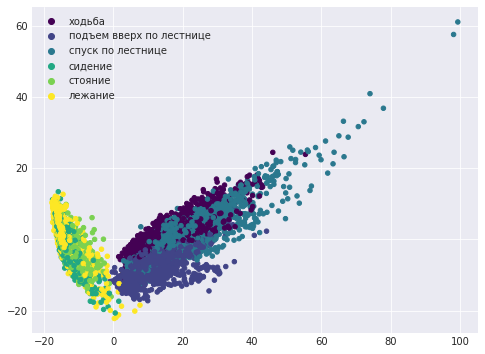

In [ ]:
# Ваш код здесь
fig, ax = plt.subplots(figsize=(8,6))
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis')

classes = {1: 'ходьба', 2: 'подъем вверх по лестнице', 3: 'спуск по лестнице', 4: 'сидение', 5: 'стояние', 6: 'лежание'}
handles, labels = scatter.legend_elements()
ax.legend(handles, classes.values());

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- **2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)**
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [ ]:
# Ваш код здесь
cluster_labels = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE, n_jobs=-1).fit_predict(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

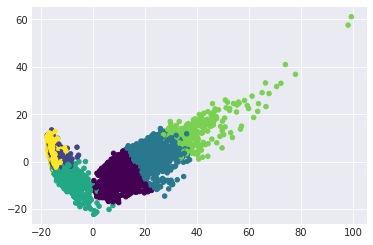

In [ ]:
# Ваш код здесь
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [ ]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,741,0,78,0,1722
подъем вверх по лестнице,1241,0,296,2,5,0,1544
спуск по лестнице,320,0,890,0,196,0,1406
сидение,1,1235,0,450,0,91,1777
стояние,0,1344,0,562,0,0,1906
лежание,5,52,0,329,0,1558,1944
все,2470,2631,1927,1343,279,1649,10299


Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- **перечисленные варианты не подходят**

In [ ]:
# Ваш код здесь
pd.Series(tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[:-1, -1], index=tab.index[:-1])

ходьба                      0.524390
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
dtype: float64

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

CPU times: user 238 ms, sys: 27.4 ms, total: 265 ms
Wall time: 3.31 s


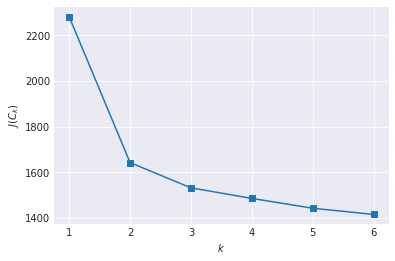

In [ ]:
%%time
# Ваш код здесь
n_k = 6
inertia = []
for k in range(1, n_k+1):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, n_k+1), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [ ]:
np.argmin([abs(inertia[i]-inertia[i+1])/abs(inertia[i-1]-inertia[i]) for i in range(1, len(inertia)-1)])+2

2

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- **2**
- 3
- 4

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [ ]:
# Ваш код здесь
metrics.adjusted_rand_score(y, ag.labels_), metrics.adjusted_rand_score(y, cluster_labels)

(0.49362763373004886, 0.4198070012602345)

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- **Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering**
- **Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры**
- **В случае случайного разбиения на кластеры ARI будет близок к нулю**

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [ ]:
# Ваш код здесь
X_train_scaled = StandardScaler().fit_transform(X_train)
X_test_scaled = StandardScaler().fit_transform(X_test)

In [ ]:
%%time
# Ваш код здесь
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
best_svc = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3).fit(X_train_scaled, y_train)

CPU times: user 6.19 s, sys: 90.5 ms, total: 6.28 s
Wall time: 47.5 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Ваш код здесь
best_svc.best_params_, best_svc.best_score_

({'C': 0.1}, 0.9382506099134881)

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- **0.1**
- 1
- 10

In [ ]:
y_predicted = best_svc.predict(X_test_scaled)

In [ ]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,479,11,4,2,0,0,496
подъем вверх по лестнице,4,465,1,1,0,0,471
спуск по лестнице,1,2,416,1,0,0,420
сидение,0,4,0,433,52,2,491
стояние,0,0,0,16,516,0,532
лежание,0,0,0,0,6,531,537
все,484,482,421,453,574,533,2947


**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- **по точности – стояние, по полноте – сидение**

In [ ]:
# Ваш код здесь
# точность
pd.Series(tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[-1, :-1], index=tab.index[:-1], name='Точность')

ходьба                      0.989669
подъем вверх по лестнице    0.964730
спуск по лестнице           0.988124
сидение                     0.955850
стояние                     0.898955
лежание                     0.996248
Name: Точность, dtype: float64

In [ ]:
# Ваш код здесь
# полнота
pd.Series(tab.iloc[:-1, :-1].max(axis=0) / tab.iloc[:-1, -1], index=tab.index[:-1], name='Полнота')

ходьба                      0.965726
подъем вверх по лестнице    0.987261
спуск по лестнице           0.990476
сидение                     0.881874
стояние                     0.969925
лежание                     0.988827
Name: Полнота, dtype: float64

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98       496
           2       0.96      0.99      0.98       471
           3       0.99      0.99      0.99       420
           4       0.96      0.88      0.92       491
           5       0.90      0.97      0.93       532
           6       1.00      0.99      0.99       537

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- **4%**
- 10%
- 20%


In [ ]:
# Ваш код здесь
pca = PCA(0.9, random_state=RANDOM_STATE)
X_train_scaled_pca = pca.fit_transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
%%time
# Ваш код здесь
svc = LinearSVC(random_state=RANDOM_STATE)
best_svc_pca = GridSearchCV(svc, svc_params, n_jobs=-1, cv=3).fit(X_train_scaled_pca, y_train)

CPU times: user 1.59 s, sys: 60.2 ms, total: 1.65 s
Wall time: 10.9 s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
# Ваш код здесь
print('Best params:', best_svc_pca.best_params_)
y_predicted_pca = best_svc_pca.predict(X_test_scaled_pca)

Best params: {'C': 0.1}


In [ ]:
acc = metrics.accuracy_score(y_test, y_predicted)
acc_pca = metrics.accuracy_score(y_test, y_predicted_pca)
acc, acc_pca, '%.1f %%' % ((acc-acc_pca) * 100)

(0.9636918900576857, 0.9185612487275195, '4.5 %')

In [ ]:
# оффтоп, памятка элементарного синтаксиса
'%06.2f' % (3.14159), '{:06.2f}'.format(3.14159), '%04d' % (42), '{:04d}'.format(42)

('003.14', '003.14', '0042', '0042')

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- **PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность**
- **PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком**